In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import Adam

from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

from imblearn.over_sampling import RandomOverSampler, SMOTE

import cv2

# address matplotlib crash issue
# https://stackoverflow.com/questions/65734044/kernel-appears-to-have-died-jupyter-notebook-python-matplotlib
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# extract elpv dataset in jupyter environment

# import zipfile
# with zipfile.ZipFile("doc.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")

In [3]:
# modified version of elpv_reader.py
# read images from images folder in root
# and convert images into data with 3 channels to facilitate training

from PIL import Image

def load_dataset(fname=None):
    if fname is None:
        fname = 'labels.csv' # modified to read from root

    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=[
                         'path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    def load_cell_image(fname): # modified to read from root/images/
        with Image.open(fname) as image:
            return np.asarray(image.convert("RGB")) # modified to read 3 channels

    images = np.array([load_cell_image(fn) # modified to read from root/images/
                       for fn in image_fnames])

    return images, probs, types

In [4]:
# load elpv dataset

images, proba, types = load_dataset()

print(images.shape)
print(proba.shape)
print(types.shape)

print(np.unique(proba))
print(np.unique(types))

(2624, 300, 300, 3)
(2624,)
(2624,)
[0.         0.33333333 0.66666667 1.        ]
['mono' 'poly']


In [5]:
# manipulate classes and labels

classes = [0, 1, 2, 3, 4, 5, 6, 7]
class_names = ["mono 0", "mono 1", "mono 2", "mono 3", "poly 0", "poly 1", "poly 2", "poly 3"]

num_classes = len(classes)
num_inputs = len(images)

labels = []

for i in range(num_inputs): # convert types and proba into 8 distinct classes
    
    q = round(proba[i], 1)
    
    if types[i] == "mono":
        if q == 0:
            labels.append(0)
        elif q == 0.3:
            labels.append(1)
        elif q == 0.7:
            labels.append(2)
        else:
            labels.append(3)
    else:
        if q == 0:
            labels.append(4)
        elif q == 0.3:
            labels.append(5)
        elif q == 0.7:
            labels.append(6)
        else:
            labels.append(7)

labels = np.array(labels)

print(images.shape)
print(labels.shape)
print(np.unique(labels))

(2624, 300, 300, 3)
(2624,)
[0 1 2 3 4 5 6 7]


(1968, 300, 300, 3) (1968,)
(656, 300, 300, 3) (656,)


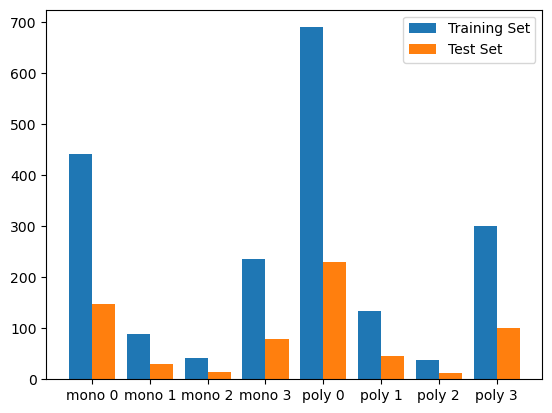

<Figure size 640x480 with 0 Axes>

In [6]:
# split shuffle stratify dataset       

sss = StratifiedShuffleSplit(n_splits=2, train_size=0.75, random_state=42)
train_index, test_index = next(sss.split(images, labels))

x_train = images[train_index]
y_train = labels[train_index]

x_test = images[test_index]
y_test = labels[test_index]

print(train_index)

# x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size=0.75, shuffle=True, stratify=labels)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

plt.bar(np.arange(num_classes) - 0.2, [list(y_train).count(i) for i in classes], label = 'Training Set', width=0.4)
plt.bar(np.arange(num_classes) + 0.2, [list(y_test).count(i) for i in classes], label = 'Test Set', width=0.4)
plt.legend(loc="upper right") 
plt.xticks(np.arange(num_classes), class_names)
plt.show()
plt.clf()

(1968, 270000) (1968,)
(5520, 270000) (5520,)
(5520, 300, 300, 3) (5520,)


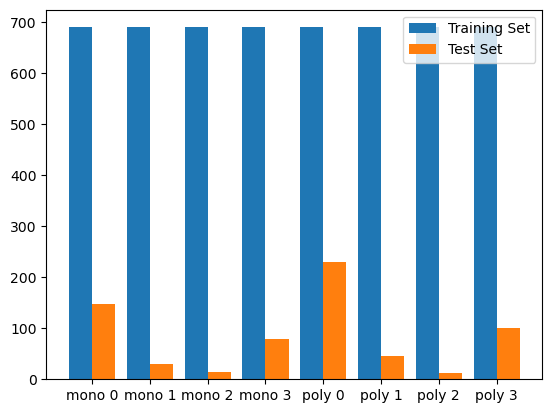

<Figure size 640x480 with 0 Axes>

In [7]:
# expand training set by over-sampling minority classes
# address class imbalance issue

x_train = x_train.reshape(-1, 300*300*3)

print(x_train.shape, y_train.shape)

oversample = RandomOverSampler(sampling_strategy='not majority') # resample all classes but the majority class
x_train, y_train = oversample.fit_resample(x_train, y_train)

print(x_train.shape, y_train.shape)

x_train = x_train.reshape(-1, 300, 300, 3)

p = np.random.permutation(len(x_train))
x_train = x_train[p]
y_train = y_train[p]

print(x_train.shape, y_train.shape)

plt.bar(np.arange(num_classes) - 0.2, [list(y_train).count(i) for i in classes], label = 'Training Set', width=0.4)
plt.bar(np.arange(num_classes) + 0.2, [list(y_test).count(i) for i in classes], label = 'Test Set', width=0.4)
plt.legend(loc="upper right") 
plt.xticks(np.arange(num_classes), class_names)
plt.show()
plt.clf()

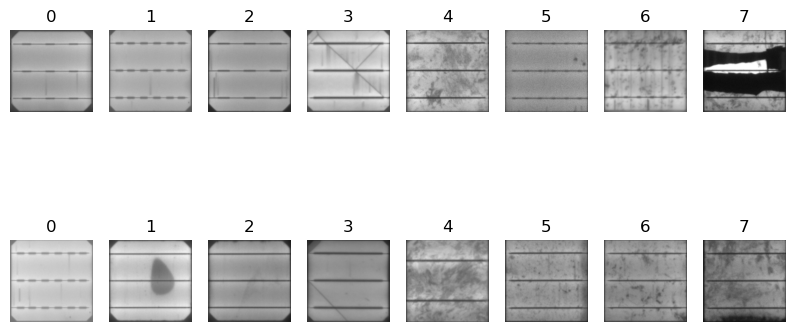

<Figure size 640x480 with 0 Axes>

In [8]:
# examine samples

fig, axs = plt.subplots(2, num_classes, figsize=(10, 5))

# show training set samples
for i in classes:
    axs[0][i].imshow(x_train[np.where(y_train == i)[0][10]])
    axs[0][i].axis('off')
    axs[0][i].set_title(i)

# show test set samples
for i in classes:
    axs[1][i].imshow(x_test[np.where(y_test == i)[0][10]])
    axs[1][i].axis('off')
    axs[1][i].set_title(i)

plt.show()
plt.clf()

In [9]:
# pre-process images with thresholding

# thresholding training set images
x_train2 = []

for i in range(len(x_train)):
    igs = cv2.cvtColor(x_train[i], cv2.COLOR_RGB2GRAY)
    if y_train[i] <= 3:
        th, ith = cv2.threshold(igs, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        th2, ith2 = cv2.threshold(igs, 80, 255,cv2.THRESH_TOZERO)
        th, ith = cv2.threshold(ith2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    irgb = cv2.cvtColor(ith, cv2.COLOR_GRAY2RGB)
    x_train2.append(irgb)

x_train = copy.deepcopy(x_train2)
x_train = np.array(x_train)
del x_train2

print(x_train.shape)

# thresholding test set images
x_test2 = []

for i in range(len(x_test)):
    igs = cv2.cvtColor(x_test[i], cv2.COLOR_RGB2GRAY)
    if y_test[i] <= 3:
        th, ith = cv2.threshold(igs, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        th2, ith2 = cv2.threshold(igs, 80, 255,cv2.THRESH_TOZERO)
        th, ith = cv2.threshold(ith2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    irgb = cv2.cvtColor(ith, cv2.COLOR_GRAY2RGB)
    x_test2.append(irgb)

x_test = copy.deepcopy(x_test2)
x_test = np.array(x_test)
del x_test2

print(x_test.shape)

(5520, 300, 300, 3)
(656, 300, 300, 3)


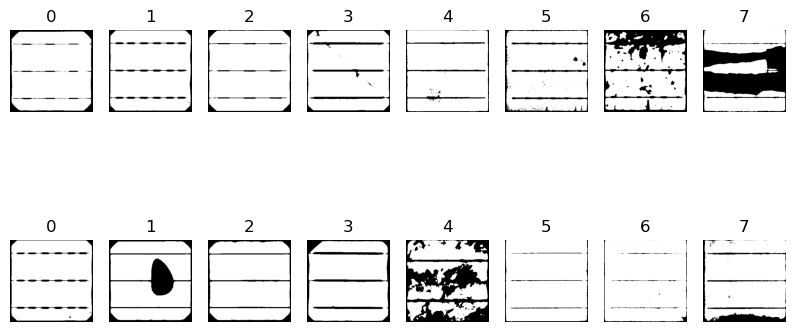

<Figure size 640x480 with 0 Axes>

In [10]:
# examine samples

fig, axs = plt.subplots(2, num_classes, figsize=(10, 5))

# show training set samples
for i in classes:
    axs[0][i].imshow(x_train[np.where(y_train == i)[0][10]])
    axs[0][i].axis('off')
    axs[0][i].set_title(i)

# show test set samples
for i in classes:
    axs[1][i].imshow(x_test[np.where(y_test == i)[0][10]])
    axs[1][i].axis('off')
    axs[1][i].set_title(i)

plt.show()
plt.clf()

In [10]:
# construct CNN model

# Simple CNN Model
# a simplified version of VGG16

# https://www.tensorflow.org/tutorials/images/classification
# https://builtin.com/machine-learning/vgg16

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # suppress errors

model = Sequential()

# model.add(layers.RandomFlip(mode="horizontal", input_shape=(300, 300, 3)))
# model.add(layers.RandomFlip(mode="vertical"))
# model.add(layers.RandomRotation(factor=(-0.01, 0.01)))
# model.add(layers.RandomZoom(height_factor=(-0.02, 0.02))) # presere aspect ratio
# model.add(layers.RandomTranslation(height_factor=(-0.02, 0.02), width_factor=(-0.02, 0.02)))

model.add(layers.Rescaling(scale=1./255, input_shape=(300, 300, 3)))

model.add(layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Dropout(rate=0.9))

model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
#model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=num_classes, activation='softmax'))

In [12]:
# compile model

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [13]:
# summarise model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 16392     
                                                        

In [14]:
# train model

num_epochs = 50

# https://medium.com/@doleron/never-use-restore-best-weights-true-with-earlystopping-754ba5f9b0c6
earlystop = EarlyStopping(monitor='val_accuracy', patience = 10, restore_best_weights = False)

checkpoint = ModelCheckpoint("handmade.keras", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

history = model.fit(x_train, y_train, epochs=num_epochs, 
                    validation_data=(x_test, y_test), batch_size=32, 
                    callbacks=[earlystop, checkpoint])

# you may manually interrupt the training after a few epochs, and use the next cell to load the model

Epoch 1/50
173/173 [==============================] - ETA: 0s - loss: 12.0637 - accuracy: 0.3614
Epoch 1: val_accuracy improved from -inf to 0.49543, saving model to vgg16.keras
173/173 [==============================] - 306s 2s/step - loss: 12.0637 - accuracy: 0.3614 - val_loss: 1.2372 - val_accuracy: 0.4954
Epoch 2/50
173/173 [==============================] - ETA: 0s - loss: 1.2806 - accuracy: 0.5183
Epoch 2: val_accuracy improved from 0.49543 to 0.53354, saving model to vgg16.keras
173/173 [==============================] - 306s 2s/step - loss: 1.2806 - accuracy: 0.5183 - val_loss: 1.3580 - val_accuracy: 0.5335
Epoch 3/50
173/173 [==============================] - ETA: 0s - loss: 1.0366 - accuracy: 0.5920
Epoch 3: val_accuracy did not improve from 0.53354
173/173 [==============================] - 306s 2s/step - loss: 1.0366 - accuracy: 0.5920 - val_loss: 1.2287 - val_accuracy: 0.4695
Epoch 4/50
173/173 [==============================] - ETA: 0s - loss: 0.8298 - accuracy: 0.6545
Ep

In [15]:
# load the best model

model = load_model("handmade.keras")

In [16]:
# compute class for each image in test set

predictions = model.predict(x_test)
#predictions = model.predict(tf.keras.applications.vgg16.preprocess_input(x_test))

y_pred = []

for i in predictions:
    y_pred.append(np.argmax(i)) # choose the class with the highest softmax normalised score

y_pred = np.array(y_pred)

21/21 [==============================] - 32s 2s/step


In [17]:
# evaluate model performance

print(f"Metrics: {model.evaluate(x_test, y_test, verbose=0)}")
#print(f"Metrics: {model.evaluate(tf.keras.applications.vgg16.preprocess_input(x_test), y_test, verbose=0)}")

Metrics: [1.3371511697769165, 0.5701219439506531]


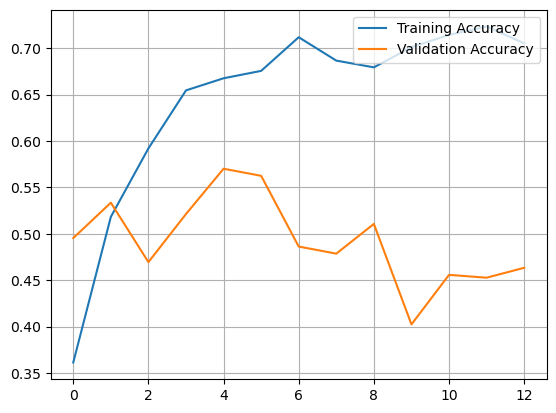

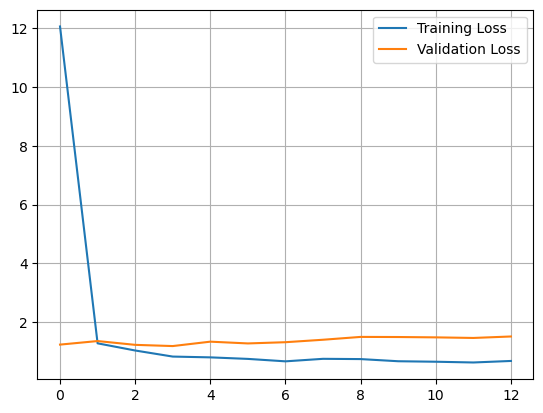

<Figure size 640x480 with 0 Axes>

In [18]:
 # visualise training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.arange(13) # change this to the number of epochs trained to reflect early stopping

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()
plt.clf()

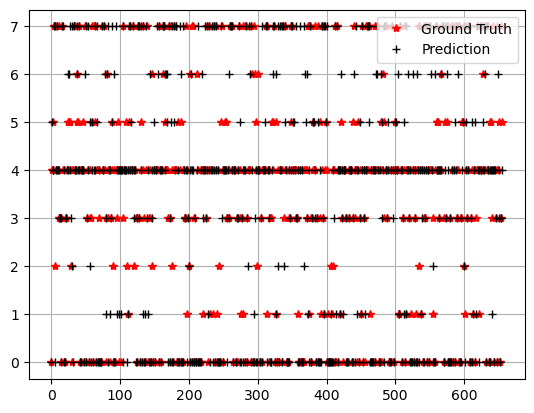

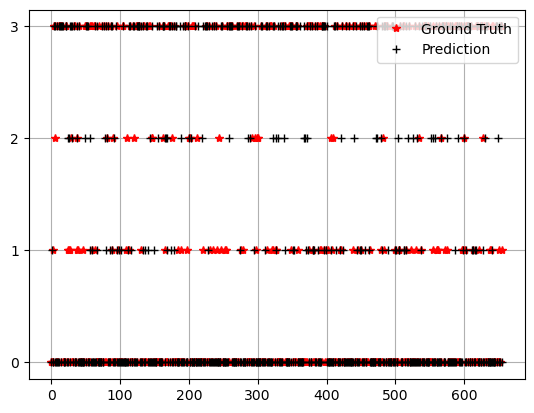

<Figure size 640x480 with 0 Axes>

In [19]:
# Ground Truth vs Prediction

plt.plot(np.arange(len(y_test)), y_test, 'r*', label='Ground Truth')
plt.plot(np.arange(len(y_pred)), y_pred, 'k+', label='Prediction')
plt.legend(loc='upper right')
plt.grid()
plt.show()
plt.clf()

# combine class
plt.plot(np.arange(len(y_test)), [i if i < 4 else i-4 for i in y_test], 'r*', label='Ground Truth')
plt.plot(np.arange(len(y_pred)), [i if i < 4 else i-4 for i in y_pred], 'k+', label='Prediction')
plt.legend(loc='upper right')
plt.yticks(np.arange(4), np.arange(4))
plt.grid()
plt.show()
plt.clf()

Accuracy: 57.77%
Precision: 58.87%
Recall: 57.77%
F1-Score: 58.27%


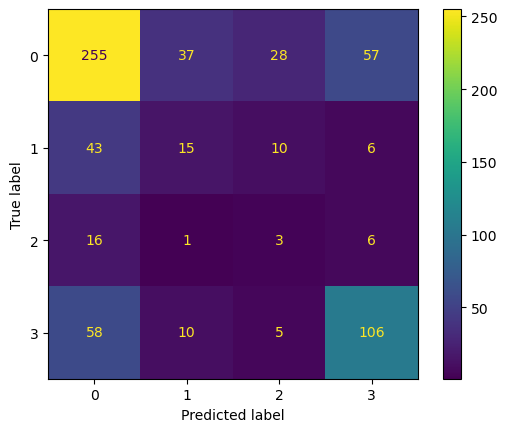

In [20]:
# Overall Performance

# a = y_test
# b = y_pred

# combine class
a = [i if i < 4 else i-4 for i in y_test]
b = [i if i < 4 else i-4 for i in y_pred]

a = np.array(a)
b = np.array(b)

print(f"Accuracy: {metrics.accuracy_score(a, b)*100:.2f}%")
print(f"Precision: {metrics.precision_score(a, b, average='weighted', labels=np.unique(b))*100:.2f}%")
print(f"Recall: {metrics.recall_score(a, b, average='weighted')*100:.2f}%")
print(f"F1-Score: {metrics.f1_score(a, b, average='weighted')*100:.2f}%")
print(metrics.classification_report(a, b, zero_division=0.0))
metrics.ConfusionMatrixDisplay.from_predictions(a, b)

Accuracy: 69.03%
Precision: 68.27%
Recall: 69.03%
F1-Score: 67.74%


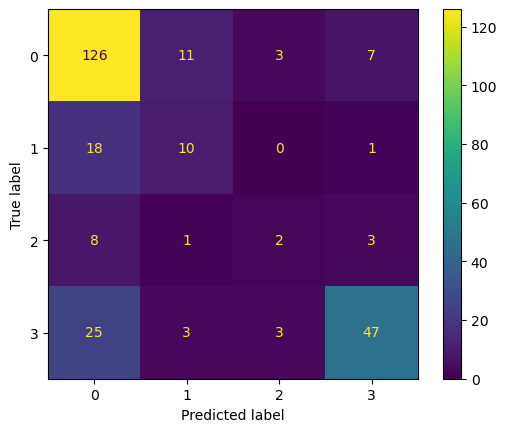

In [21]:
# Mono Performance

a = [i for i in y_test if i <= 3]
b = y_pred[[i for i,g in enumerate(y_test) if g <= 3]]

# combine class
for i in range(len(b)):
    if b[i] > 3:
        b[i] -= 4

a = np.array(a)
b = np.array(b)

print(f"Accuracy: {metrics.accuracy_score(a, b)*100:.2f}%")
print(f"Precision: {metrics.precision_score(a, b, average='weighted', labels=np.unique(b))*100:.2f}%")
print(f"Recall: {metrics.recall_score(a, b, average='weighted', labels=np.unique(a))*100:.2f}%")
print(f"F1-Score: {metrics.f1_score(a, b, average='weighted')*100:.2f}%")
print(metrics.classification_report(a, b, zero_division=0.0))
metrics.ConfusionMatrixDisplay.from_predictions(a, b)

Accuracy: 50.00%
Precision: 53.95%
Recall: 50.00%
F1-Score: 51.60%


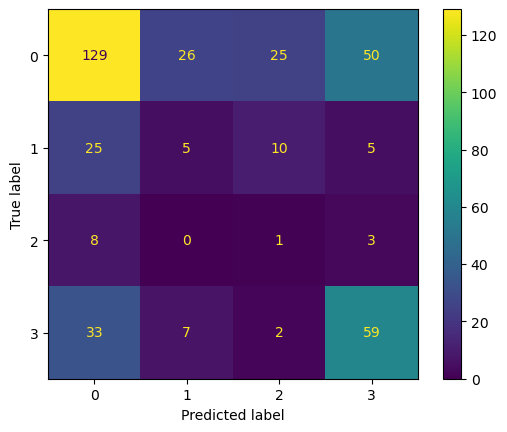

In [22]:
# Poly Performance

a = [i for i in y_test if i > 3]
b = y_pred[[i for i,g in enumerate(y_test) if g > 3]]

# combine class
for i in range(len(b)):
    if b[i] < 4:
        b[i] += 4

a = np.array(a) - 4
b = np.array(b) - 4

print(f"Accuracy: {metrics.accuracy_score(a, b)*100:.2f}%")
print(f"Precision: {metrics.precision_score(a, b, average='weighted', labels=np.unique(b))*100:.2f}%")
print(f"Recall: {metrics.recall_score(a, b, average='weighted', labels=np.unique(a))*100:.2f}%")
print(f"F1-Score: {metrics.f1_score(a, b, average='weighted')*100:.2f}%")
print(metrics.classification_report(a, b, zero_division=0.0))
metrics.ConfusionMatrixDisplay.from_predictions(a, b)

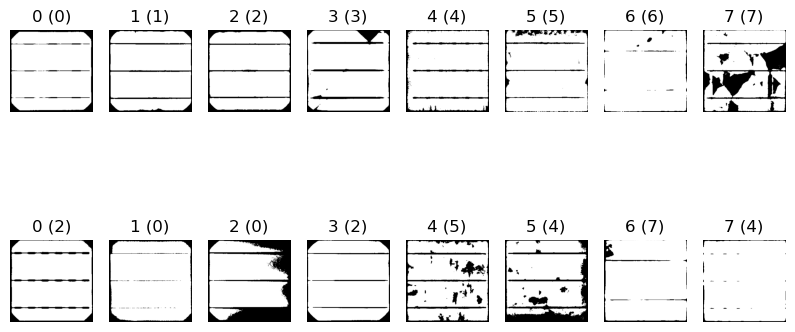

<Figure size 640x480 with 0 Axes>

In [23]:
# examine result samples

fig, axs = plt.subplots(2, num_classes, figsize=(10, 5))

# show successful test samples
for i in classes:
    for q in range(len(y_test)):
        if y_test[q] == i:
            if y_pred[q] == y_test[q]:
                axs[0][i].imshow(x_test[q])
                axs[0][i].set_title(f"{i} ({y_pred[q]})")
                break
    axs[0][i].axis('off')

# show failed test samples
for i in classes:
    for q in range(len(y_test)):
        if y_test[q] == i:
            if y_pred[q] != y_test[q]:
                axs[1][i].imshow(x_test[q])
                axs[1][i].set_title(f"{i} ({y_pred[q]})")
                break
    axs[1][i].axis('off')

plt.show()
plt.clf()